In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daybikedataset/day.csv
/kaggle/input/hourbikedataset/hour.csv


In [2]:
# file = open("/kaggle/input/daybikedataset/day.csv", "rb")
# file = open("/kaggle/input/d/vedika27agarwal/daybikedataset/day.csv", "rb")
file = open("/kaggle/input/hourbikedataset/hour.csv", "rb")

data_r = file.readlines()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# data_arr = np.genfromtxt('/kaggle/input/daybikedataset/day.csv', delimiter=',', dtype=np.float64, skip_header=1)
# data_arr = np.genfromtxt('/kaggle/input/d/vedika27agarwal/daybikedataset/day.csv', delimiter=',', dtype=np.float64, skip_header=1)
data_arr = np.genfromtxt('/kaggle/input/hourbikedataset/hour.csv', delimiter=',', dtype=np.float64, skip_header=1)
# data_arr = data_arr[:, 10:12]*100
data_arr = data_arr[:, 11:13]*100

In [4]:
print(data_arr.shape)

(17379, 2)


In [5]:
print(data_arr)

[[28.79 81.  ]
 [27.27 80.  ]
 [27.27 80.  ]
 ...
 [25.76 60.  ]
 [27.27 56.  ]
 [27.27 65.  ]]


In [6]:
data_arr = data_arr.astype(int)
print(data_arr)

[[28 81]
 [27 80]
 [27 80]
 ...
 [25 60]
 [27 56]
 [27 65]]


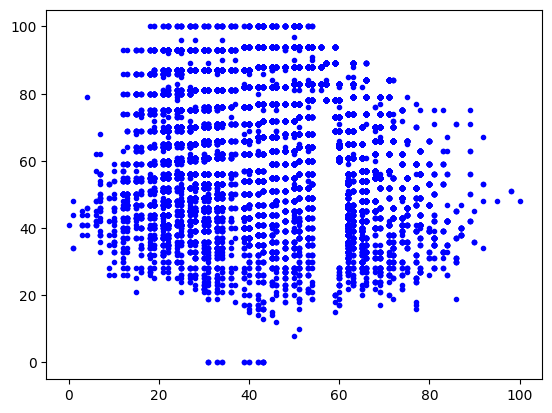

In [7]:
import random

random_seed = 6
data_freq = 15000
# data = data_arr[:data_freq, :]
random.seed(random_seed)
indices = random.sample(range(data_arr.shape[0]), data_freq)

data = data_arr[indices, :]

plt.plot(data[:, 0], data[:, 1], marker='.', linestyle=' ', color='blue', label='Bike Data')

In [8]:
def _1flat(p1, p2):
    '''
    Returns the m, c values from the eqn y = mx + c, which is the eqn of the line formed by joining points p1 and p2
    If p1 == p2, we return line with slope 1
    If p1_x == p2_x, m = None and c = x_intercept
    Otherwise, m = slope and c = y_intercept
    '''
    
    if (p2[0] == p1[0]):
        if (p2[1] == p1[1]):
            return 1, p1[1] - p1[0]
        
        return None, p1[0]
    
    m = (p2[1] - p1[1]) / (p2[0] - p1[0])
    c = round(p1[1] - m*p1[0], 2)
    
    return round(m, 2), c

In [9]:
import math

def find_dist(pt, line):
    if line[0] == None:
        return math.fabs(pt[0] - line[1])
    
    numerator = math.fabs(line[0]*pt[0] - pt[1] + line[1])
    denominator = math.sqrt(1 + line[0]**2)
    
    return round(numerator/denominator, 7)

def find_min_dist(pt, F):
    F = list(F)
    min_dist = find_dist(pt, F[0])
    for line in F[1:]:
        cur_dist = find_dist(pt, line)
        min_dist = min(min_dist, cur_dist)
    
    return min_dist

In [10]:
import heapq

def Approx_k_j_Flats(P, C, k=1, j=1):
    
    t = 1
    Q = P
    F = set()
    F_len_mid = None
    
    while Q.shape[0] >= C*k*(j+1):
#         S_len = int(np.log2((j+1)) + min(t, np.log2(np.log2(data_freq))))
        S_len = 1
#         random.seed(7*t-1) # 1, 3, 5
        indx_S0 = random.sample(range(Q.shape[0]), S_len)
#         random.seed(7*t)   # 2, 4, 6
        indx_S1 = random.sample(range(Q.shape[0]), S_len)
        
        F_ = set()
        for i in range(S_len):
            for j in range(S_len):
                F_.add(_1flat(Q[indx_S0[i]], Q[indx_S1[j]]))
        
        F.update(F_)
        
        min_dist_rec = [] # Contains lists [dist, indx] as elements where dist = min distance of point Q[indx] from closest line
        Q_index = 0
        for pt in Q:
            min_dist_rec.append((-1*find_min_dist(pt, F_), Q_index))
            Q_index += 1
        
        heapq.heapify(min_dist_rec)
        
        Q_ = []
        for i in range(Q.shape[0]//2):
            Q_.append(Q[heapq.heappop(min_dist_rec)[1]])
        
        Q = np.array(Q_)
        t += 1
    
    F_len_mid = len(F)
    
    for pt1 in Q:
        for pt2 in Q:
            F.add(_1flat(pt1, pt2))
    
    return Q, F.copy(), F_len_mid

In [11]:
def plotPoint(P, clr, marker='o'):
    plt.plot(P[:, 0], P[:, 1], marker=marker, linestyle=' ', color=clr)
    
def plotLine(m, c, clr):
    if m==None:
        x1, y1, x2, y2 = c, 0, c, 100
    elif m==0:
        x1, y1, x2, y2 = 0, c, 100, c
    else:
        x1, y1, x2, y2 = 0, c, -c/m, 0
    if x2!=x1:
        x = np.linspace(min(x1, x2) - 100, max(x1, x2) + 100, 100)        
        y = m * (x - x1) + y1
        plt.plot(x, y, linestyle='-', color=clr)
    else:
        plt.plot([x1, y1], [x2, y2], linestyle='-', color=clr)

In [12]:
def find_k_j_flats(data, C): 

    '''
    Calls Approx-K-J-Flats and returns the output F in the form of a list
    '''
    
    Q_2, F_2, F_len_mid = Approx_k_j_Flats(data, C)
    F_2 = list(F_2)

#     plotPoint(Q_2, 'red')
#     for line in F_2:
#         plotLine(line[0], line[1])

#     data_view = data.view([('', data.dtype)] * data.shape[1])
#     Q_2_view = Q_2.view([('', Q_2.dtype)] * Q_2.shape[1])

#     Q_3 = np.setdiff1d(data_view, Q_2_view).view(data.dtype).reshape(-1, data.shape[1])

#     plotPoint(Q_3, 'blue')

#     plt.xlim(-25, 100)
#     plt.ylim(-25, 125)
#     plt.show()
    
    return F_2, F_len_mid

In [13]:
def find_optimal_l_centrum(F, l, P):
    
    '''
    For each point in P, distance is calculated from:
        -the optimal line in F
        -its closest line in F
    '''
    
    flag = True
    optimalLine = None #One line in F that for  which sum of max_l_distances is minimum
    optimalDistances = [] #Distance of each point from this selected optimalLine
    closestDistances = [] #Distance of each point from its closest line in F
    first_line_flag = True
    
    for line in F:
        distances = []
        for pt in range(len(P)):
            d = find_dist(P[pt], line)
            distances.append(d)
            
            if first_line_flag:
                closestDistances.append(d)
            else:
                closestDistances[pt] = min(closestDistances[pt], d)
        
        first_line_flag = False
        distances.sort(reverse=True)
        
        max_l_sum = sum(distances[:l])
        
        if flag:
            optimalDistance = max_l_sum
            flag = False
            
        optimalDistance = min(optimalDistance, max_l_sum)
        
        if optimalDistance == max_l_sum:
            optimalLine = line
            optimalDistances = distances
            
    closestDistances.sort(reverse=True)
    return optimalLine, optimalDistances, closestDistances

In [14]:
def find_optimal_dist_sum(data, l, F):
    '''
        Calls find_optimal_l_centrum
        Computes and returns values of objective function when:
            -centre = 1 optimal line
            -centre = F (set of lines)
        Also returns the optimal line
    '''
    L_1, D_1, D_n = find_optimal_l_centrum(F, l, data)
    optimal_max_l_dist_sum  = sum(D_1[:l]) #Sum of max_l_distances for 1 line
    optimal_closest_l_dist_sum = sum(D_n[:l]) #Sum of max_l_distances for F set

#     plotPoint(data, 'red')
#     plotLine(L_1[0], L_1[1])

#     plt.xlim(-25, 100)
#     plt.ylim(-25, 125)
#     plt.show()

    return optimal_closest_l_dist_sum, optimal_max_l_dist_sum, L_1

In [15]:
%%time

min_dist_overall_rec = []
closest_dist_overall_rec = []
F_len_rec = []
F_len_mid_rec = []

for iter in range(50):
    print(iter)
    min_dist_sum = [-1, -1, -1] #value of optimised objective function
    optimal_line = [None, None, None] #line (in F) that optimises the objective function
    optimal_C = [0, 0, 0] #value of C for which value of objective function is minimum
    ell_values = [1, data.shape[0]//2, data.shape[0]]
    min_dist_rec = [[], [], []] #Value of objective function for each C
    closest_dist_rec = [[], [], []] #Sum of distances of every point to closest line in F generated for each C

    for i in range(1, 11):
        F, F_len_mid = find_k_j_flats(data, i) # C = i
        if iter==1:
            F_len_rec.append(len(F))
            F_len_mid_rec.append(F_len_mid)
        for l in range(3):
            cur_closest_sum, cur_dist_sum, cur_line = find_optimal_dist_sum(data, ell_values[l], F)
            if i == 1 or cur_dist_sum < min_dist_sum[l]:
                min_dist_sum[l] = cur_dist_sum
                optimal_line[l] = cur_line
                optimal_C[l] = i
            
            closest_dist_rec[l].append(cur_closest_sum)
            min_dist_rec[l].append(cur_dist_sum)
    
    closest_dist_overall_rec.append(closest_dist_rec)
    min_dist_overall_rec.append(min_dist_rec)

    
#     for l in range(3):
#         plt.subplot(3, 1, l + 1)
#         plt.plot(range(1, 15), min_dist_rec[l])
#         plt.plot([11], [min_dist_rec[l][10]], marker='o', linestyle=" ", color="red")
#         plt.title("ell = " + str(ell_values[l]))
#         plt.xlabel("Values of C")
#         if l==1:
#             plt.ylabel("Sum of 'ell' max distances")
    #     plt.ylim(0, None)

#     plt.show()

print(F_len_rec)

min_dist_overall_rec = np.array(min_dist_overall_rec)
closest_dist_overall_rec = np.array(closest_dist_overall_rec)
mean_min_dist = [[], [], []]
mean_closest_dist = [[], [], []]
for i in range(1, 11):
    mean_min_dist[0].append(np.mean(min_dist_overall_rec[:, 0, i-1]))
    mean_min_dist[1].append(np.mean(min_dist_overall_rec[:, 1, i-1]))
    mean_min_dist[2].append(np.mean(min_dist_overall_rec[:, 2, i-1]))
    mean_closest_dist[0].append(np.mean(closest_dist_overall_rec[:, 0, i-1]))
    mean_closest_dist[1].append(np.mean(closest_dist_overall_rec[:, 1, i-1]))
    mean_closest_dist[2].append(np.mean(closest_dist_overall_rec[:, 2, i-1]))

# print("ell = " + str(ell_values[0]) + ": Optimal C = " + str(np.argmin(np.array(mean_dist[0])) + 1))
# print("ell = " + str(ell_values[1]) + ": Optimal C = " + str(np.argmin(np.array(mean_dist[1])) + 1))
# print("ell = " + str(ell_values[2]) + ": Optimal C = " + str(np.argmin(np.array(mean_dist[2])) + 1))

# for l in range(3):
#     plt.subplot(3, 1, l + 1)
#     plt.plot(range(1, 15), mean_dist[l])
#     plt.plot([11], [mean_dist[l][10]], marker='o', linestyle=" ", color="red")
#     plt.title("ell = " + str(ell_values[l]))
#     plt.xlabel("Values of C")
#     if l==1:
#         plt.ylabel("Mean Sum of 'ell' max distances")

# plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
[14, 11, 13, 11, 18, 15, 18, 30, 33, 30]
CPU times: user 18min 40s, sys: 260 ms, total: 18min 40s
Wall time: 18min 42s


ell = 1: Optimal C = 10
ell = 7500: Optimal C = 1
ell = 15000: Optimal C = 1


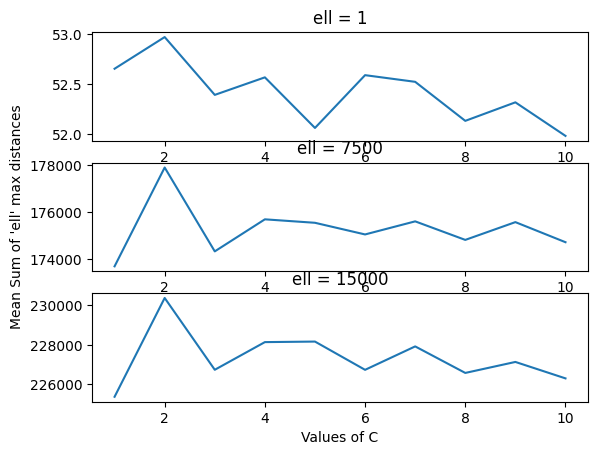

In [16]:
print("ell = " + str(ell_values[0]) + ": Optimal C = " + str(np.argmin(np.array(mean_min_dist[0])) + 1))
print("ell = " + str(ell_values[1]) + ": Optimal C = " + str(np.argmin(np.array(mean_min_dist[1])) + 1))
print("ell = " + str(ell_values[2]) + ": Optimal C = " + str(np.argmin(np.array(mean_min_dist[2])) + 1))

for l in range(3):
    plt.subplot(3, 1, l + 1)
    plt.plot(range(1, 11), mean_min_dist[l])
    plt.title("ell = " + str(ell_values[l]))
    plt.xlabel("Values of C")
    if l==1:
        plt.ylabel("Mean Sum of 'ell' max distances")

plt.show()

ell = 1: Optimal C = 8
ell = 7500: Optimal C = 8
ell = 15000: Optimal C = 8


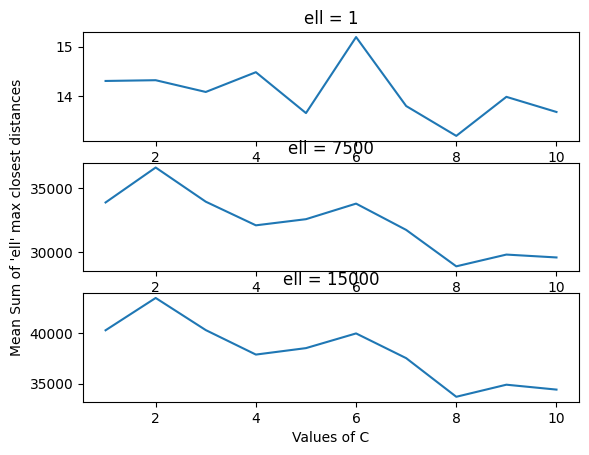

In [17]:
print("ell = " + str(ell_values[0]) + ": Optimal C = " + str(np.argmin(np.array(mean_closest_dist[0])) + 1))
print("ell = " + str(ell_values[1]) + ": Optimal C = " + str(np.argmin(np.array(mean_closest_dist[1])) + 1))
print("ell = " + str(ell_values[2]) + ": Optimal C = " + str(np.argmin(np.array(mean_closest_dist[2])) + 1))

for l in range(3):
    plt.subplot(3, 1, l + 1)
    plt.plot(range(1, 11), mean_closest_dist[l])
    plt.title("ell = " + str(ell_values[l]))
    plt.xlabel("Values of C")
    if l==1:
        plt.ylabel("Mean Sum of 'ell' max closest distances")

plt.show()

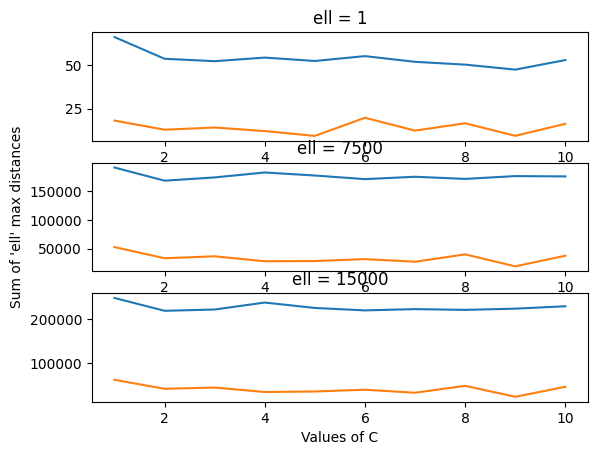

In [18]:
min_dist_sum = [-1, -1, -1]
line_C_13 = [None, None, None]
optimal_C = [0, 0, 0]
ell_values = [1, data.shape[0]//2, data.shape[0]]
min_dist_rec = [[], [], []]
closest_dist_rec = [[], [], []]
# line_C_13 = [None, None, None]
# F_len_rec = []

for i in range(1, 11):
    F, _ = find_k_j_flats(data, i)
#     print(i, F_len_rec[i-1])
#     F_len_rec.append(len(F))
    for l in range(3):
        closest_dist_sum, cur_dist_sum, cur_line = find_optimal_dist_sum(data, ell_values[l], F)
        min_dist_rec[l].append(cur_dist_sum)
        closest_dist_rec[l].append(closest_dist_sum)
        
        if i == 1 or cur_dist_sum < min_dist_sum[l]:
            min_dist_sum[l] = cur_dist_sum
            optimal_line[l] = cur_line
            optimal_C[l] = i
        
        if i == 9:
            line_C_13[l] = cur_line

for l in range(3):
    plt.subplot(3, 1, l + 1)
    plt.plot(range(1, 11), min_dist_rec[l])
    plt.plot(range(1, 11), closest_dist_rec[l])
#     plt.plot([13], [min_dist_rec[l][12]], marker='o', linestyle=" ", color="red")
    plt.title("ell = " + str(ell_values[l]))
    plt.xlabel("Values of C")
    if l==1:
        plt.ylabel("Sum of 'ell' max distances")
#     plt.ylim(0, None)

plt.show()

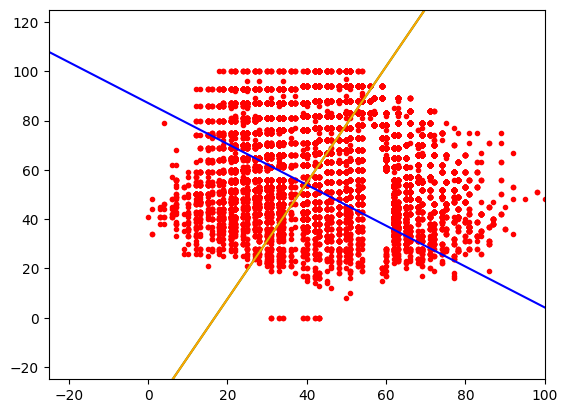

In [19]:
plotPoint(data, "red", marker=".")
plotLine(line_C_13[0][0], line_C_13[0][1], clr="blue")
plotLine(line_C_13[1][0], line_C_13[1][1], clr="green")
plotLine(line_C_13[2][0], line_C_13[2][1], clr="orange")
plt.xlim(-25, 100)
plt.ylim(-25, 125)

plt.show()

In [20]:
import pandas as pd

data_l_1 = {
    'C' : range(1, 11),
    'Loop Size of F': F_len_mid_rec,
    'Final Size of F' : F_len_rec,
    'All of F': mean_closest_dist[0],
    '1 Optimal Line from F': mean_min_dist[0]
}

df_1 = pd.DataFrame(data_l_1)

print("ell =", ell_values[0])
print()
print(df_1)

ell = 1

    C  Loop Size of F  Final Size of F   All of F  1 Optimal Line from F
0   1              14               14  14.303701              52.655239
1   2              11               11  14.318894              52.972421
2   3              12               13  14.080189              52.393388
3   4              11               11  14.481551              52.568958
4   5              12               18  13.651313              52.062372
5   6              12               15  15.195076              52.590918
6   7              12               18  13.794478              52.524161
7   8              11               30  13.188199              52.133271
8   9              11               33  13.981026              52.318722
9  10              11               30  13.673725              51.982768


In [21]:
import pandas as pd

# mean_min_dist = np.array(mean_min_dist)
# mean_closest_dist = np.array(mean_closest_dist)

data_l_half = {
    'C' : range(1, 11),
    'Loop Size of F': F_len_mid_rec,
    'Final Size of F' : F_len_rec,
    'All of F': mean_closest_dist[1],
    '1 Optimal Line from F': mean_min_dist[1]
}

df_half = pd.DataFrame(data_l_half)

print("ell =", ell_values[1])
print()
print(df_half)

ell = 7500

    C  Loop Size of F  Final Size of F      All of F  1 Optimal Line from F
0   1              14               14  33899.522780          173679.769434
1   2              11               11  36634.750271          177894.724995
2   3              12               13  33960.162561          174317.592302
3   4              11               11  32111.317741          175684.618380
4   5              12               18  32591.955836          175536.832993
5   6              12               15  33809.696370          175039.828661
6   7              12               18  31751.658373          175598.043129
7   8              11               30  28902.667251          174807.350458
8   9              11               33  29822.846029          175565.497482
9  10              11               30  29597.289264          174708.749478


In [22]:
import pandas as pd

# mean_min_dist = np.array(mean_min_dist)
# mean_closest_dist = np.array(mean_closest_dist)

data_l_full = {
    'C' : range(1, 11),
    'Loop Size of F': F_len_mid_rec,
    'Final Size of F' : F_len_rec,
    'All of F': mean_closest_dist[2],
    '1 Optimal Line from F': mean_min_dist[2]
}

df_full = pd.DataFrame(data_l_full)

print("ell =", ell_values[2])
print()
print(df_full)

ell = 15000

    C  Loop Size of F  Final Size of F      All of F  1 Optimal Line from F
0   1              14               14  40282.799304          225379.500093
1   2              11               11  43488.737429          230369.330259
2   3              12               13  40300.832802          226743.051230
3   4              11               11  37871.691297          228139.688133
4   5              12               18  38512.429187          228167.019670
5   6              12               15  39970.235829          226740.377085
6   7              12               18  37516.355541          227923.296980
7   8              11               30  33684.709182          226583.470398
8   9              11               33  34883.557968          227138.585782
9  10              11               30  34397.440169          226308.667707
